In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import time

In [3]:

df = pd.read_csv('scada.csv')

In [5]:

df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')
df.set_index('Date/Time', inplace=True)
df = df.sort_index()
df.dropna(inplace=True)


In [7]:

df['Wind Speed Rolling_3'] = df['Wind Speed (m/s)'].rolling(window=3).mean()
df['Theoretical vs Active'] = df['Theoretical_Power_Curve (KWh)'] - df['LV ActivePower (kW)']
df.dropna(inplace=True)  
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)',
            'Wind Speed Rolling_3', 'Theoretical vs Active']
target = 'LV ActivePower (kW)'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features = scaler_x.fit_transform(df[features])
scaled_target = scaler_y.fit_transform(df[[target]])


In [9]:
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 24  
X, y = create_sequences(scaled_features, scaled_target, time_steps)

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:

model_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

In [15]:

model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [17]:
start_time = time.time()

In [19]:

history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0404 - mae: 0.1314 - val_loss: 0.0139 - val_mae: 0.0744
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0146 - mae: 0.0806 - val_loss: 0.0134 - val_mae: 0.0752
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0130 - mae: 0.0742 - val_loss: 0.0098 - val_mae: 0.0610
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0112 - mae: 0.0683 - val_loss: 0.0084 - val_mae: 0.0547
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0097 - mae: 0.0637 - val_loss: 0.0074 - val_mae: 0.0504
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0090 - mae: 0.0611 - val_loss: 0.0074 - val_mae: 0.0542
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0081 - mae: 0.0581 - val_loss: 0.0061 - val_mae: 0.0470
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0072 - mae: 0.0552 - val_loss: 0.0059 - val_mae: 0.0477
Epoch 9/50
1011/1011 ━━━

In [20]:

end_time = time.time()


training_time = end_time - start_time

print(f"Training Time: {training_time:.2f} seconds")

Training Time: 759.79 seconds


In [21]:

y_pred_lstm = model_lstm.predict(X_test)

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled_lstm = scaler_y.inverse_transform(y_pred_lstm)

In [23]:

mse_lstm = mean_squared_error(y_test_rescaled, y_pred_rescaled_lstm)
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled_lstm)
r2_lstm = r2_score(y_test_rescaled, y_pred_rescaled_lstm)


In [24]:
print(f"LSTM SCADA-only - MSE: {mse_lstm}, MAE: {mae_lstm}, R^2: {r2_lstm}")


LSTM SCADA-only - MSE: 87612.24035175102, MAE: 191.07782375339923, R^2: 0.9486413335656536


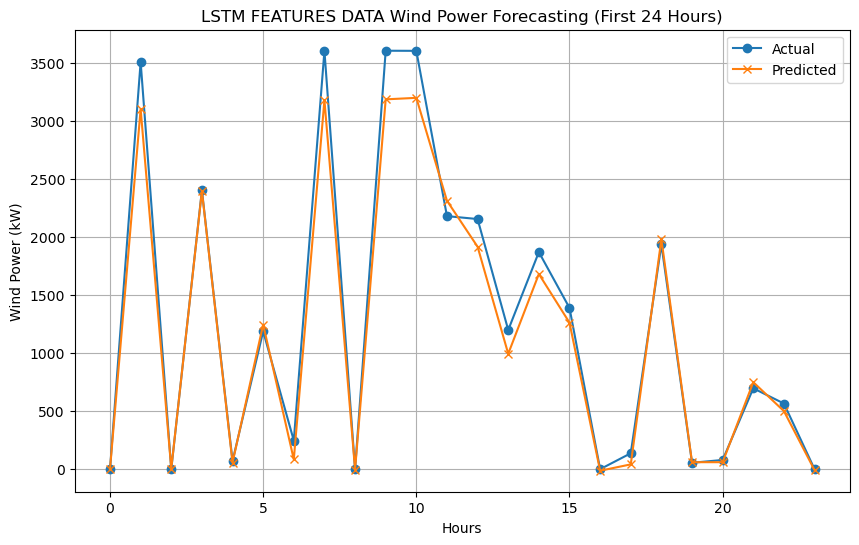

In [25]:
import matplotlib.pyplot as plt
hours = range(24)  
plt.figure(figsize=(10, 6))
plt.plot(hours, y_test_rescaled[:24].flatten(), label='Actual', marker='o')
plt.plot(hours, y_pred_rescaled_lstm[:24].flatten(), label='Predicted', marker='x')
plt.title('LSTM FEATURES DATA Wind Power Forecasting (First 24 Hours)')
plt.xlabel('Hours')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

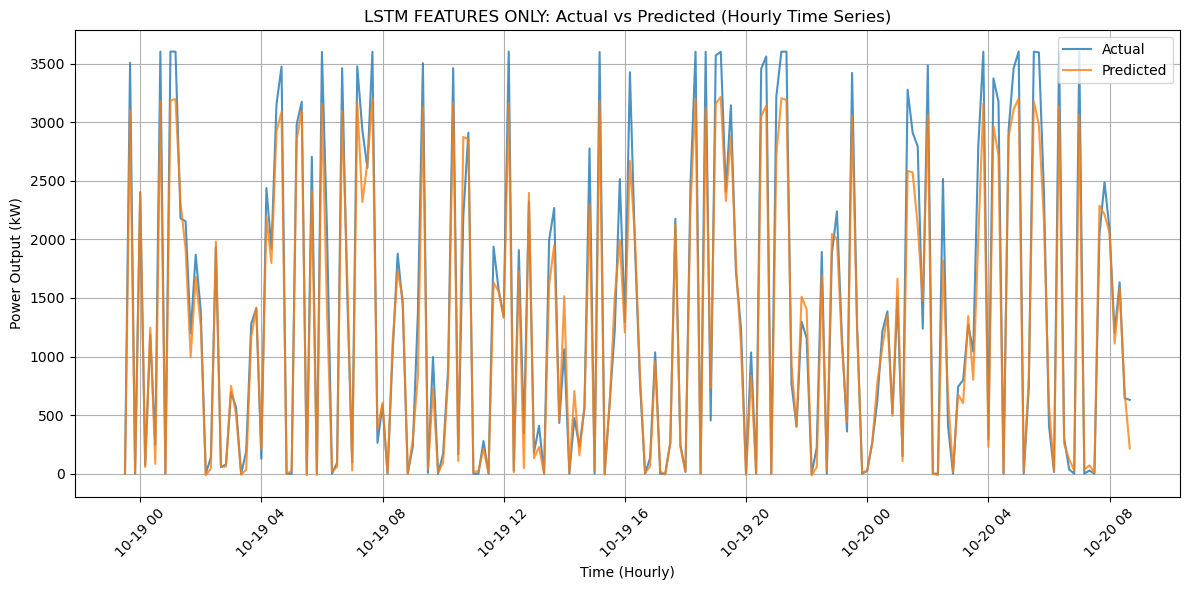

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_rescaled):][:200], y_test_rescaled[:200], label="Actual", alpha=0.8)
plt.plot(df.index[-len(y_pred_rescaled_lstm):][:200], y_pred_rescaled_lstm[:200], label="Predicted", alpha=0.8)
plt.title("LSTM FEATURES ONLY: Actual vs Predicted (Hourly Time Series)")
plt.xlabel("Time (Hourly)")
plt.ylabel("Power Output (kW)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Create a DataFrame with actual, predicted, and timestamps
results_df = pd.DataFrame({
    'Timestamp': df.index[-len(y_test_rescaled):],  
    'Actual': y_test_rescaled.flatten(),           
    'Predicted': y_pred_rescaled_lstm.flatten()
})

# Display the first 200 rows
print(results_df.head(200))

# Save as CSV if needed
results_df.to_csv('predicted_vs_actual.csv', index=False)

              Timestamp       Actual    Predicted
0   2018-10-18 23:30:00     0.000000     0.681864
1   2018-10-18 23:40:00  3507.781006  3101.644043
2   2018-10-18 23:50:00     0.000000     3.276889
3   2018-10-19 00:00:00  2402.625000  2395.250244
4   2018-10-19 00:10:00    70.224953    56.176586
..                  ...          ...          ...
195 2018-10-20 08:00:00  2080.305908  2056.360840
196 2018-10-20 08:10:00  1204.432983  1110.615356
197 2018-10-20 08:20:00  1633.077026  1580.548340
198 2018-10-20 08:30:00   643.873413   685.816467
199 2018-10-20 08:40:00   629.860718   215.503662

[200 rows x 3 columns]
